In [1]:
import cira

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

In [3]:
SYMBOL = "MSFT"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

ast = cira.Stock(SYMBOL)


if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2000, 1, 1)
    end = datetime.now().date() 
    ast.save_historical_data(SYM_HIST_FILE, start, end)

data = ast.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,MSFT,48.18,48.61,47.36,48.61,59379610.0,272783.0,48.05
2016-01-05 05:00:00+00:00,MSFT,48.72,49.13,48.38,48.83,36457804.0,180639.0,48.83
2016-01-06 05:00:00+00:00,MSFT,48.18,48.25,47.58,47.94,41899187.0,225858.0,47.99
2016-01-07 05:00:00+00:00,MSFT,46.75,47.44,46.19,46.28,61897908.0,303273.0,46.64
2016-01-08 05:00:00+00:00,MSFT,46.45,47.26,46.26,46.42,52260304.0,261924.0,46.74


<Axes: xlabel='timestamp'>

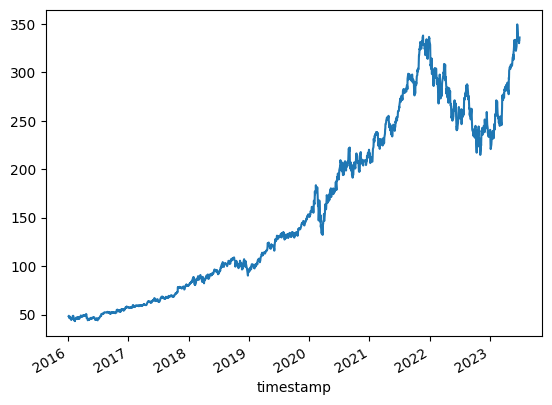

In [4]:
data["open"].plot()

<Axes: xlabel='timestamp'>

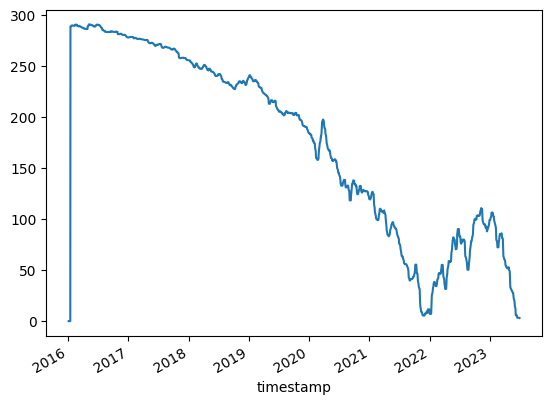

In [5]:

data["diff"] = (data["open"].values[-1] - data["open"]).rolling(10).median()
data["diff"] = data["diff"].fillna(0)
data["diff"].plot()

In [6]:
classes = {
    "nueatral": 0,
    "light_buy": 1,
    "light_sell": 2,
    "hard_buy": 3,
    "hard_sell":4,
}

<Axes: xlabel='signal'>

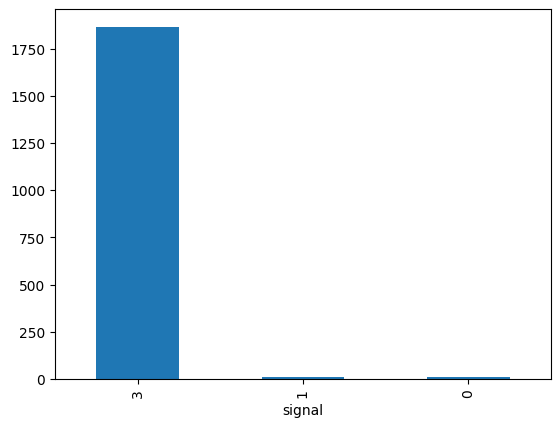

In [7]:
data["signal"] = classes["nueatral"]
data.loc[data["diff"] > 2, "signal"] = classes["light_buy"]
data.loc[data["diff"] < -5, "signal"] = classes["light_sell"]
data.loc[data["diff"] > 4, "signal"] = classes["hard_buy"]
data.loc[data["diff"] < -15, "signal"] = classes["hard_sell"]
data["signal"].value_counts().plot.bar()

In [8]:
data.drop(columns=["symbol"], inplace=True)
data.head()

,open,high,low,close,volume,trade_count,vwap,diff,signal
timestamp,,,,,,,,,
2016-01-04 05:00:00+00:00,48.18,48.61,47.36,48.61,59379610.0,272783.0,48.05,0.0,0
2016-01-05 05:00:00+00:00,48.72,49.13,48.38,48.83,36457804.0,180639.0,48.83,0.0,0
2016-01-06 05:00:00+00:00,48.18,48.25,47.58,47.94,41899187.0,225858.0,47.99,0.0,0
2016-01-07 05:00:00+00:00,46.75,47.44,46.19,46.28,61897908.0,303273.0,46.64,0.0,0
2016-01-08 05:00:00+00:00,46.45,47.26,46.26,46.42,52260304.0,261924.0,46.74,0.0,0


In [9]:
y = data["signal"].to_frame()
X = data.drop(columns=["diff"], inplace=False)

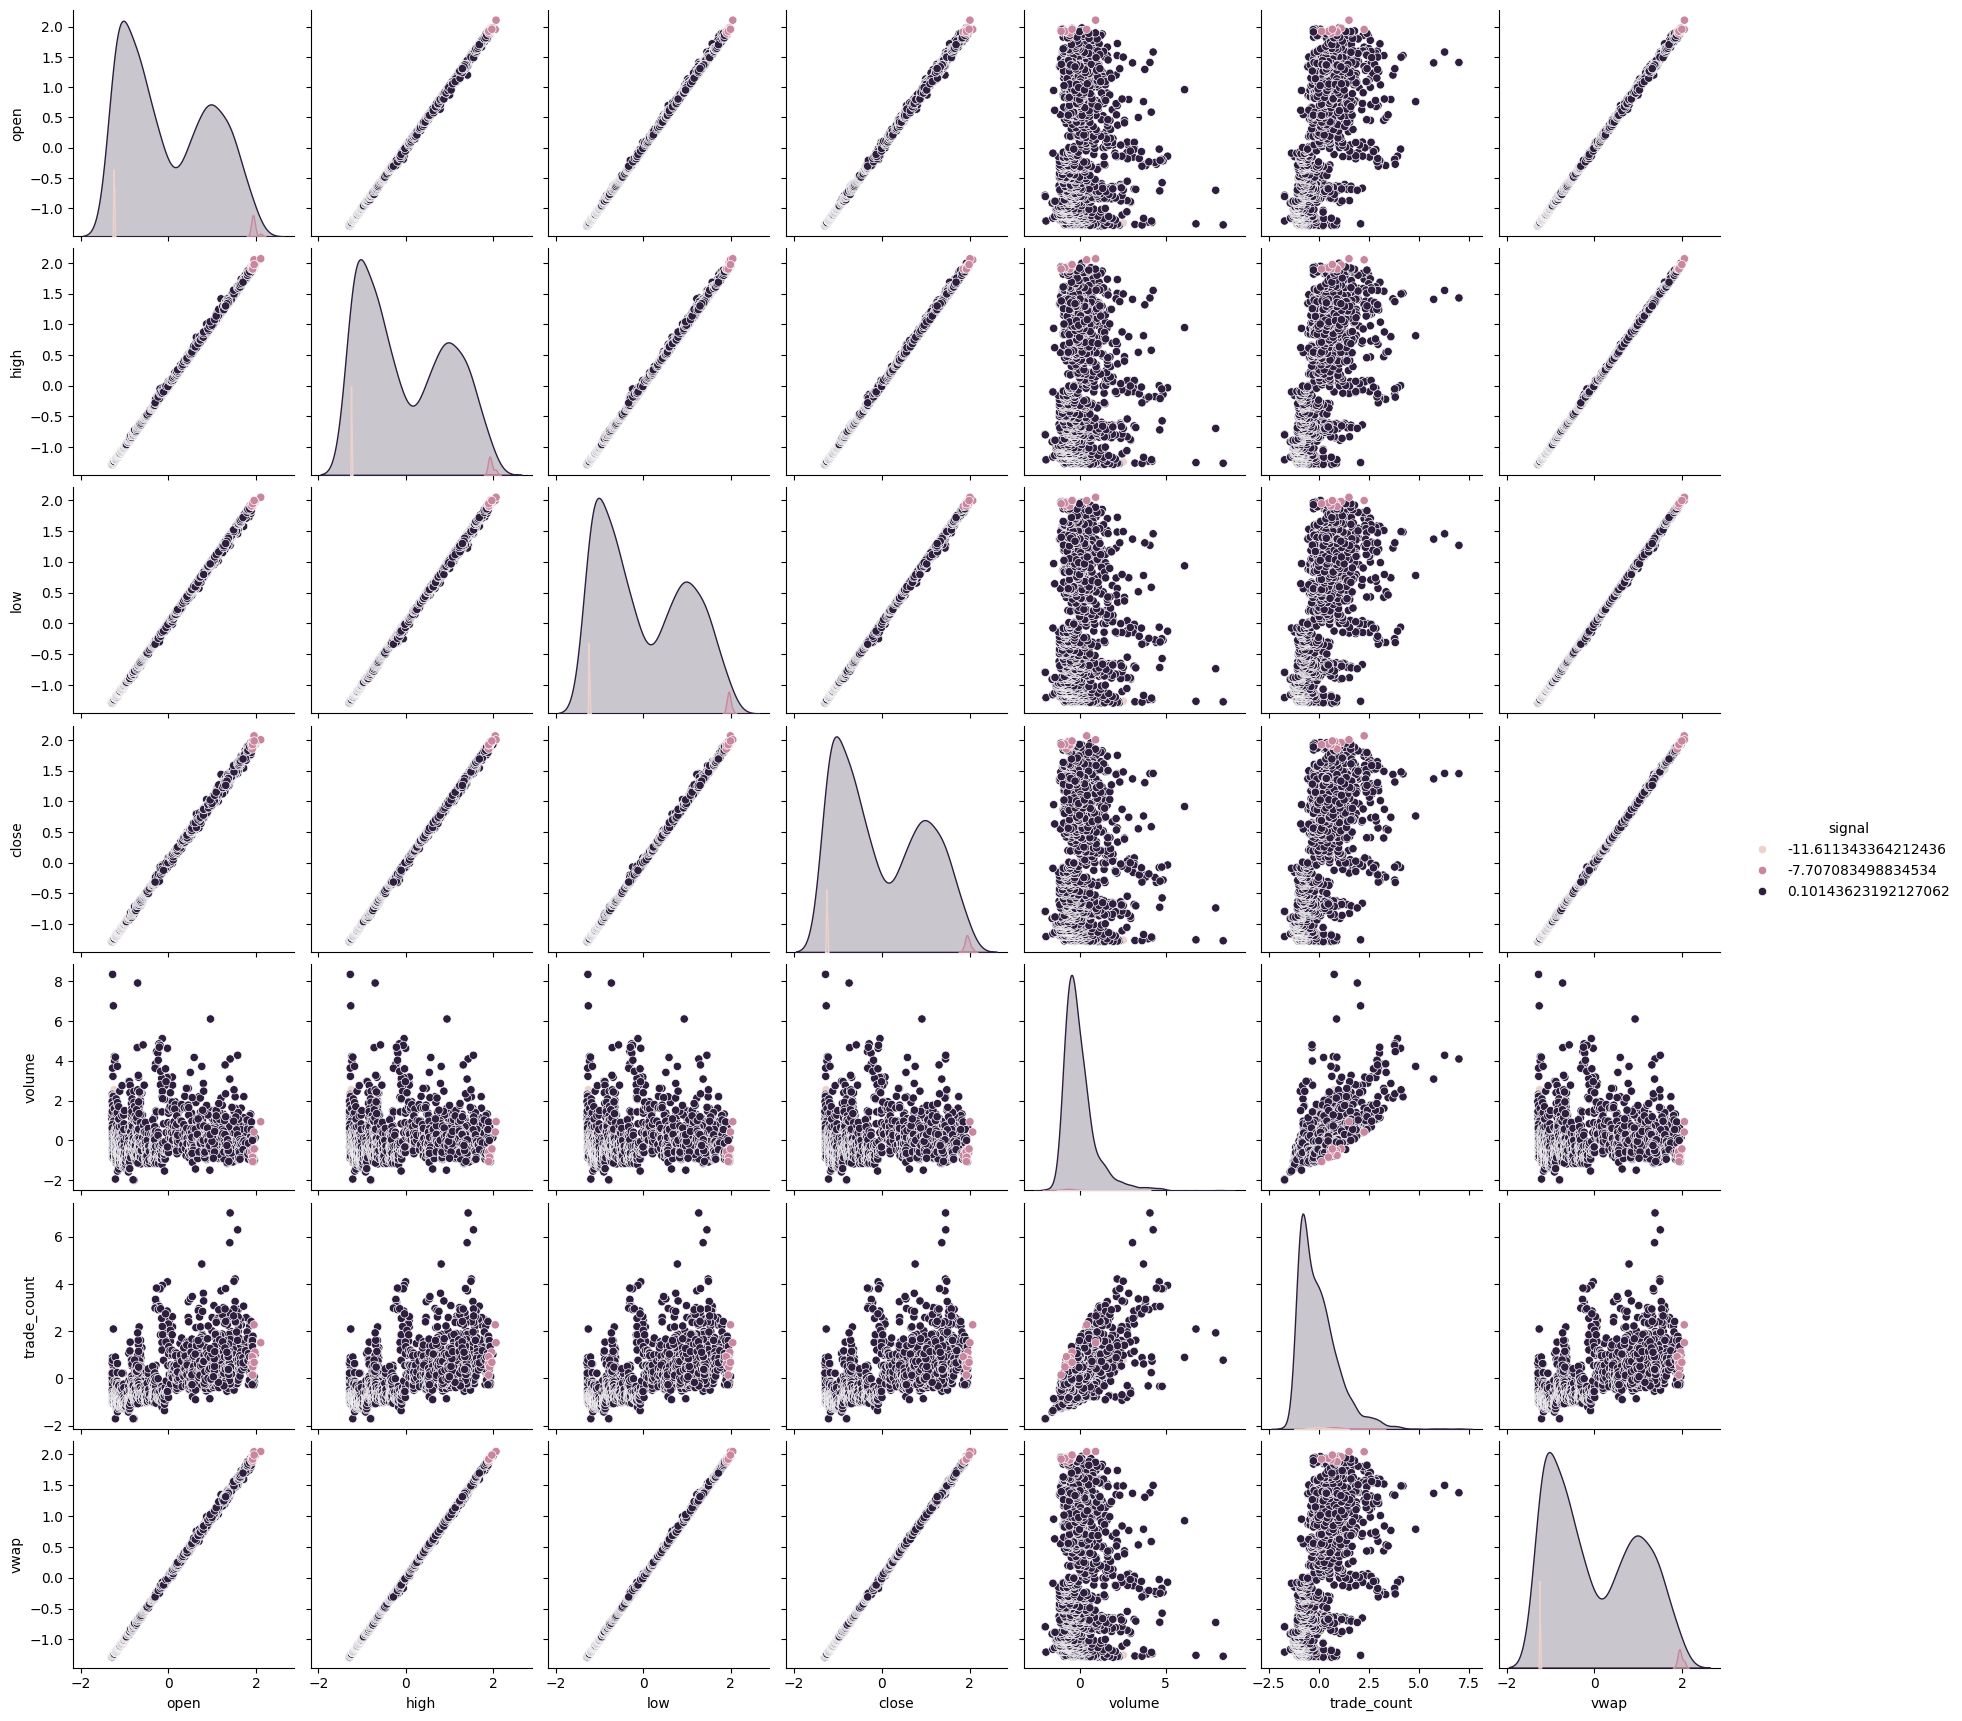

In [10]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(X), columns=X.keys())

sns.pairplot(scaled_data, hue="signal")

In [11]:
split_prc = 0.9
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1697 189


In [12]:
X_train = train_data.drop(columns=["signal", "diff"], inplace=False)
y_train = train_data["signal"]

print(X_train.shape, y_train.shape)

X_test = test_data.drop(columns=["signal", "diff"], inplace=False)
y_test = test_data["signal"]

print(X_test.shape, y_test.shape)
X_train.keys()

(1697, 7) (1697,)
(189, 7) (189,)


Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')

<Axes: xlabel='timestamp'>

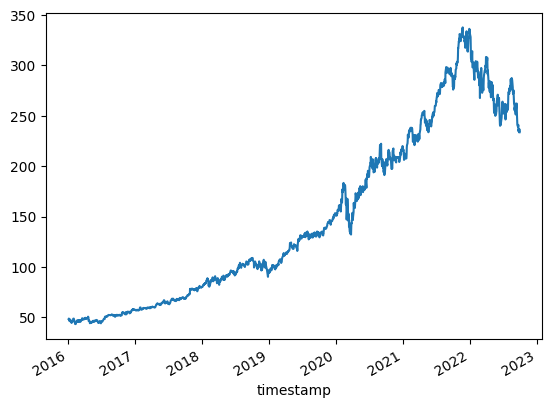

In [13]:
train_data["open"].plot()

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=8)
print(X_train.keys())
model = model.fit(X_train, y_train)

Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).

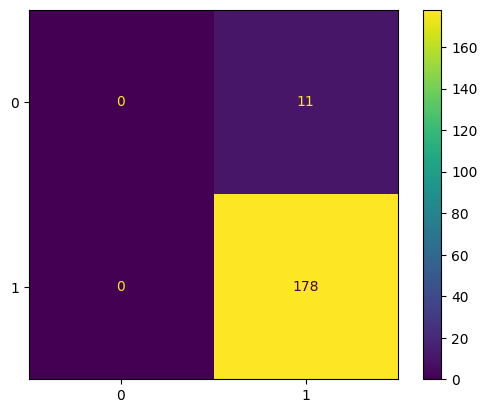

In [15]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes.keys()))
cmd.plot()

In [ ]:

from numpy import ndarray
from pandas import DataFrame


class KNN_Strategy(cira.strategy.Strategy):
    def __init__(self, model:KNeighborsClassifier, scaler: StandardScaler) -> None:
        super().__init__(name="KNN")
        self.model = model
        self.allocation = list()
        self.scaler = scaler
        self.preds = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray:
        X_scaled = self.scaler.transform(feature_data)
        pred = model.predict(X_scaled)[-1]
        self.preds.append(pred)
        max_al = (cash / prices.values[-1])[0]
        max_sell = (portfolio[-1] / prices.values[-1])[0]
        actions = {
            classes["nueatral"]: 0,
            classes["light_buy"]: max_al*0.01,
            classes["light_sell"]: -max_sell*0.2,
            classes["hard_buy"]: max_al*0.5,
            classes["hard_sell"]: -max_sell*0.8,
        }

        al = np.array([actions[pred]])
        #al = np.array([0])
        self.allocation.append(portfolio[-1])
        return al 

In [ ]:
X_test.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-08-15 04:00:00+00:00,35.05,35.26,34.40,34.42,27420330.0,154846.0,34.72
2023-08-16 04:00:00+00:00,34.17,34.28,33.12,33.19,35760465.0,193985.0,33.46
2023-08-17 04:00:00+00:00,33.22,33.25,32.02,32.25,39908138.0,217162.0,32.36
2023-08-18 04:00:00+00:00,31.90,32.57,31.85,32.42,23701058.0,135050.0,32.33
2023-08-21 04:00:00+00:00,32.27,32.83,31.69,32.80,43718847.0,181435.0,32.33


/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, bu

Delta: 1146.65$


/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, bu

<Axes: xlabel='timestamp'>

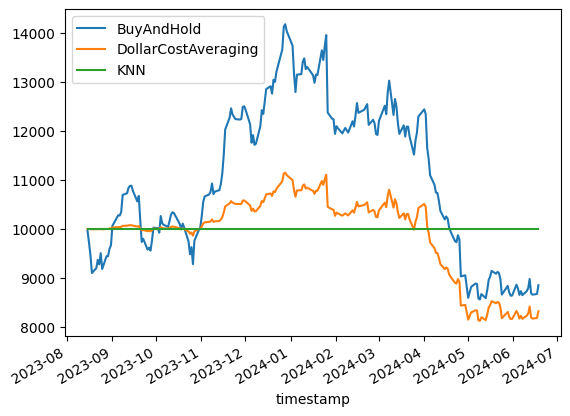

In [ ]:
s = StandardScaler()
s.fit(X_train)
strat = KNN_Strategy(model, s)
#X_backtest = test_data.drop(columns=["signal", "diff"], inplace=False)
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], X_test, X_test["open"].to_frame(), 10_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
bt.plot()